## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from collections import defaultdict
from functools import partial
from itertools import count
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag
import string
import re
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.cross_validation import KFold
from sklearn.svm import SVC
%matplotlib inline

//anaconda/lib/python3.4/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

## Train Folders

In [3]:
descriptionTrainFolder = "~/Documents/final/data/descriptions_train"
featuresTrainFolder = "~/Documents/final/ddata/features_train"
imagesTrainFolder = "~/Documents/final/ddata/images_train"
tagsTrainFolder = "~/Documents/final/ddata/tags_train"

## Test Folders

In [4]:
descriptionTestFolder = "~/Documents/final/ddata/descriptions_test"
featuresTestFolder = "~/Documents/final/ddata/features_test"
imagesTestFolder = "~/Documents/final/ddata/images_test"
tagsTestFolder = "~/Documents/final/ddata/tags_test"

## Number of files

In [5]:
numTrain = 10000
numTest = 2000

## Read Files

In [6]:
def readTagsFile(fileName):
    tags = []
    f = open(fileName,"r")
    for line in f:
        line = line.split(":") # possibly also consider using the keys in each line(vehicle,outdoor etc..)
        tag = line[-1].replace("\n","")
        tags.append(tag)
    return tags

def readDescriptionFile(fileName):
    desc = []
    f = open(fileName,"r")
    for line in f:
        noPuncSentence = stripPunctuation(line)
        desc.append(noPuncSentence)
    return desc

def stripPunctuation(s):
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    return regex.sub(' ', s)

## Tags Analysis

In [7]:
def getTagDict(num,tagFolder):
    tags = {}
    for n in range(num):
        f = tagFolder +"/" + str(n) + ".txt"
        fileTags = readTagsFile(f)
        #newTags = stemTags(fileTags)
        for tag in fileTags:
            if str(tag) not in tags.keys():
                tags[str(tag)] = 0
            else:
                tags[str(tag)] +=1
    return tags

In [8]:
tagDict = getTagDict(numTrain,tagsTrainFolder)

In [9]:
print (tagDict)

{'cat': 354, 'scissors': 72, 'dining table': 959, 'parking meter': 57, 'sink': 389, 'surfboard': 321, 'fork': 267, 'hot dog': 121, 'vase': 310, 'chair': 1029, 'couch': 344, 'orange': 130, 'suitcase': 188, 'tennis racket': 293, 'wine glass': 214, 'baseball glove': 198, 'bench': 475, 'truck': 498, 'umbrella': 357, 'apple': 106, 'stop sign': 141, 'toilet': 287, 'person': 5322, 'bear': 86, 'cup': 746, 'fire hydrant': 151, 'baseball bat': 193, 'keyboard': 169, 'backpack': 428, 'clock': 441, 'traffic light': 327, 'hair drier': 11, 'sports ball': 339, 'train': 330, 'zebra': 168, 'cake': 216, 'cell phone': 436, 'bus': 330, 'teddy bear': 183, 'bicycle': 284, 'car': 1021, 'handbag': 597, 'toaster': 23, 'snowboard': 128, 'carrot': 138, 'bowl': 592, 'airplane': 221, 'bird': 305, 'oven': 246, 'sandwich': 207, 'kite': 200, 'motorcycle': 327, 'potted plant': 356, 'knife': 331, 'frisbee': 194, 'banana': 169, 'donut': 117, 'dog': 391, 'tie': 305, 'cow': 177, 'toothbrush': 79, 'spoon': 292, 'boat': 276,

In [10]:
print (list(tagDict.keys()))

['cat', 'scissors', 'dining table', 'parking meter', 'sink', 'surfboard', 'fork', 'hot dog', 'vase', 'chair', 'couch', 'orange', 'suitcase', 'tennis racket', 'wine glass', 'baseball glove', 'bench', 'truck', 'umbrella', 'apple', 'stop sign', 'toilet', 'person', 'bear', 'cup', 'fire hydrant', 'baseball bat', 'keyboard', 'backpack', 'clock', 'traffic light', 'hair drier', 'sports ball', 'train', 'zebra', 'cake', 'cell phone', 'bus', 'teddy bear', 'bicycle', 'car', 'handbag', 'toaster', 'snowboard', 'carrot', 'bowl', 'airplane', 'bird', 'oven', 'sandwich', 'kite', 'motorcycle', 'potted plant', 'knife', 'frisbee', 'banana', 'donut', 'dog', 'tie', 'cow', 'toothbrush', 'spoon', 'boat', 'microwave', 'book', 'giraffe', 'elephant', 'skis', 'pizza', 'bed', 'broccoli', 'skateboard', 'tv', 'remote', 'bottle', 'refrigerator', 'sheep', 'horse', 'laptop', 'mouse']


In [11]:
print (list(tagDict.values()))

[354, 72, 959, 57, 389, 321, 267, 121, 310, 1029, 344, 130, 188, 293, 214, 198, 475, 498, 357, 106, 141, 287, 5322, 86, 746, 151, 193, 169, 428, 441, 327, 11, 339, 330, 168, 216, 436, 330, 183, 284, 1021, 597, 23, 128, 138, 592, 221, 305, 246, 207, 200, 327, 356, 331, 194, 169, 117, 391, 305, 177, 79, 292, 276, 112, 446, 217, 178, 237, 265, 314, 162, 256, 351, 239, 707, 204, 122, 218, 303, 158]


In [12]:
def plotTagFrequency(d):
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar(range(len(d)), list(d.values()), align='center')
    plt.xticks(range(len(d)), list(d.keys()), rotation=90)

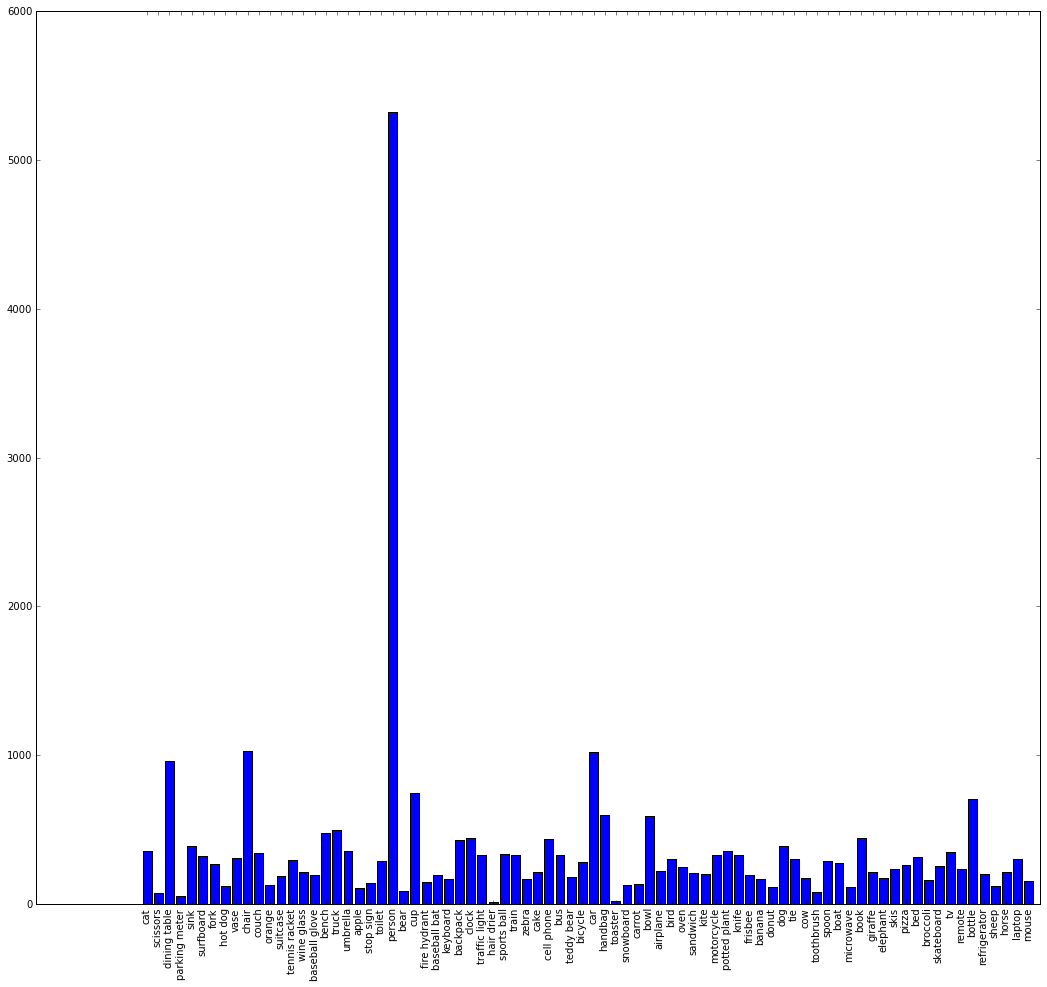

In [13]:
plotTagFrequency(tagDict)

The least frequent tags are easier to use in classification, whereas more frequent tags are harder to use to point to a specific image. This could help us understand which tags are more important than others when trying to determine the best tag out of a tie.

In [14]:
def plotTagNormalizeFrequency(d):
    newValues = [freq/float(sum(d.values())) for freq in list(d.values())]
    plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.bar(range(len(d)), newValues, align='center')
    plt.xticks(range(len(d)), list(d.keys()), rotation=90)

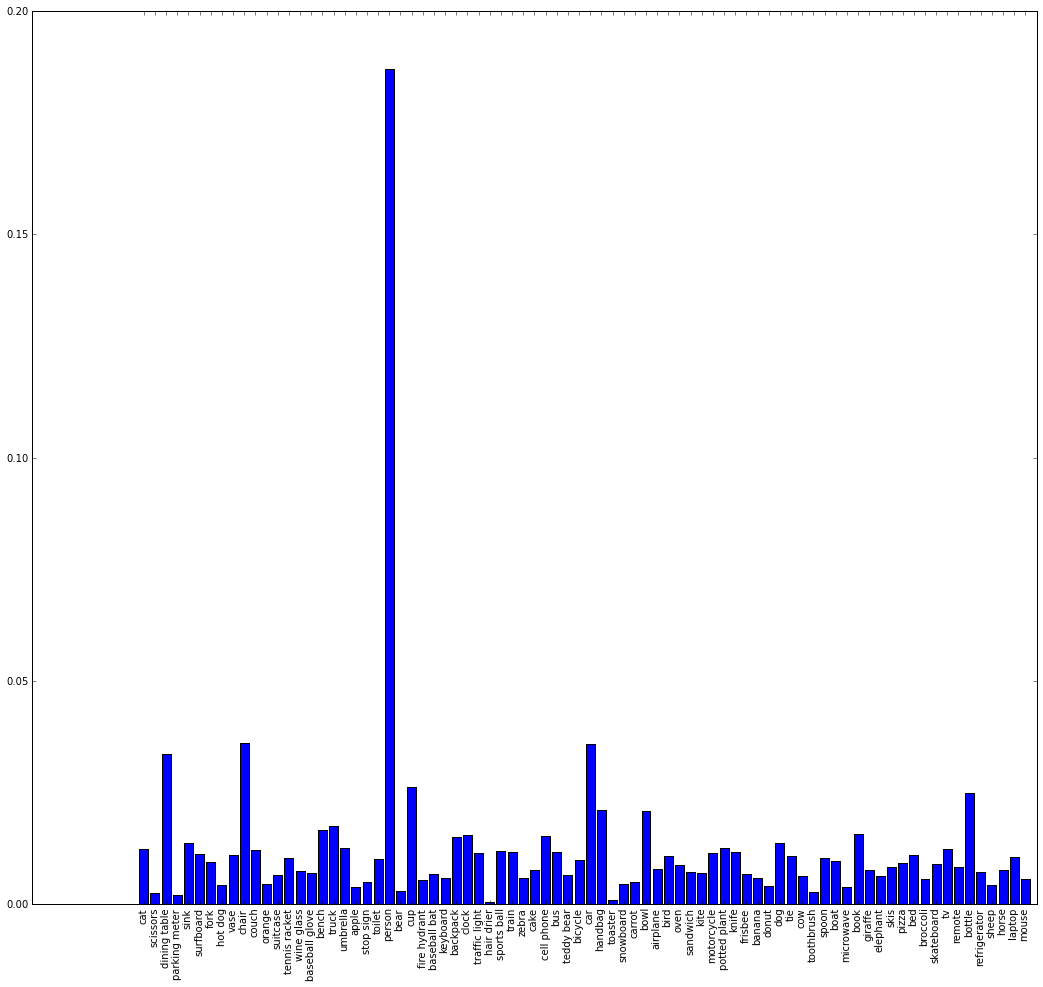

In [15]:
plotTagNormalizeFrequency(tagDict)

In [16]:
print (tagDict['chair']/float(sum(tagDict.values())))

0.03616744578397947


## Description Processing

In [17]:
def getStopWords():
    return set(stopwords.words("english"))

def lowerCase(x):
    return x.lower()

def lemmatize(lmt,x):
    return lmt.lemmatize(x)


def getPos(line):
    return pos_tag(line)

def preProcess(num,descFolder):
    descWords = []
    #lemmatizer = WordNetLemmatizer()  #option
    stemmer = PorterStemmer()
    stopWords  = getStopWords()
    for n in range(num):
        fileWordFreq = []
        fileWordFreq2 = []
        f = descFolder +"/" + str(n) + ".txt"
        fileDescriptions = readDescriptionFile(f)
        for desc in fileDescriptions:
            posDesc = getPos(desc.split())
            for word,pos in posDesc:
                #print word,pos
#                 if pos == "NN" or pos == "NNS" and word not in stopWords and word != " ":
                lowerWord = lowerCase(word)
                if lowerWord not in stopWords and lowerWord != " ":
                    #lemmatizedWord = lemmatize(lemmatizer, unicode(word)) #option
                    stemmedWord = stemmer.stem(lowerWord)
                    #fileWordFreq.append(str(lemmatizedWord))
                    fileWordFreq.append(str(stemmedWord))
        descWords.append(fileWordFreq)
    return np.array(descWords)

In [19]:
words = preProcess(numTrain,descriptionTrainFolder)

In [21]:
print (words)

[ ['skateboard', 'put', 'show', 'use', 'picnic', 'tabl', 'stage', 'skateboard', 'pull', 'trick', 'top', 'picnic', 'tabl', 'man', 'ride', 'skateboard', 'top', 'tabl', 'skate', 'boarder', 'trick', 'picnic', 'tabl', 'person', 'ride', 'skateboard', 'picnic', 'tabl', 'crowd', 'watch']
 ['bowl', 'soup', 'carrot', 'shrimp', 'noodl', 'healthi', 'food', 'bowl', 'readi', 'eat', 'soup', 'carrot', 'shrimp', 'sit', 'next', 'chopstick', 'tasti', 'bowl', 'ramen', 'serv', 'someon', 'enjoy', 'bowl', 'asian', 'noodl', 'soup', 'shrimp', 'carrot']
 ['man', 'walk', 'across', 'street', 'busi', 'intersect', 'ice', 'cream', 'truck', 'drive', 'man', 'walk', 'behind', 'ice', 'cream', 'truck', 'man', 'cross', 'street', 'near', 'icecream', 'truck', 'man', 'walk', 'behind', 'concess', 'bu']
 ...,
 ['bunch', 'paper', 'cover', 'wall', 'bedroom', 'bed', 'sit', 'next', 'lamp', 'nightstand', 'small', 'bedroom', 'bed', 'small', 'tabl', 'bed', 'night', 'stand', 'quilt', 'type', 'background', 'behind', 'bed', 'room', 'bed

In [23]:
def createBag(num,tagFolder):
    tags = {}
    for n in range(num):
        f = tagFolder +"/" + str(n) + ".txt"
        fileTags = readTagsFile(f)
        newTags = stemTags(fileTags)
        for t in newTags:
            if t not in tags.keys():
                tags[t] = 0
    return tags

def stemTags(lst):
    newTags = []
    for word in lst:
        stem = str(PorterStemmer().stem(word))
        newTags.append(stem)
    return newTags

def indexBag(bag):
    idx = 0
    for tag in bag.keys():
        bag[tag] = idx
        idx+=1
    return bag

def getTagVectored(num,tagFolder,bag):
    tagVecs = np.zeros((num,len(bag.keys())))
    for n in range(num):
        f = tagFolder +"/" + str(n) + ".txt"
        fileTags = readTagsFile(f)
        newTags = stemTags(fileTags)
        for tag in newTags:
            if tag in bag.keys():
                tagVecs[n,bag[tag]] = 1
            else:
                print (str(tag) + " is not in the tag BOW")
    return tagVecs

In [26]:
tagVector = getTagDict(3,tagsTrainFolder)

In [27]:
bow = createBag(numTrain,tagsTrainFolder)

In [28]:
indexedBOW = indexBag(bow)

In [30]:
print (indexedBOW)

{'cat': 0, 'eleph': 1, 'motorcycl': 2, 'surfboard': 3, 'refriger': 4, 'vase': 5, 'chair': 6, 'cell phon': 7, 'toaster': 8, 'cow': 9, 'spoon': 10, 'tennis racket': 11, 'hot dog': 12, 'orang': 13, 'wine glass': 14, 'bench': 15, 'truck': 16, 'giraff': 17, 'stop sign': 18, 'airplan': 19, 'person': 20, 'remot': 21, 'cup': 22, 'couch': 23, 'baseball bat': 24, 'keyboard': 25, 'suitcas': 26, 'baseball glov': 27, 'traffic light': 28, 'bottl': 29, 'sandwich': 30, 'train': 31, 'sink': 32, 'frisbe': 33, 'hair drier': 34, 'pizza': 35, 'mous': 36, 'bu': 37, 'hors': 38, 'teddy bear': 39, 'scissor': 40, 'car': 41, 'fork': 42, 'handbag': 43, 'snowboard': 44, 'carrot': 45, 'bear': 46, 'bowl': 47, 'toilet': 48, 'cake': 49, 'bird': 50, 'oven': 51, 'parking met': 52, 'kite': 53, 'clock': 54, 'knife': 55, 'umbrella': 56, 'donut': 57, 'dog': 58, 'tie': 59, 'dining t': 60, 'boat': 61, 'sports bal': 62, 'book': 63, 'appl': 64, 'ski': 65, 'microwav': 66, 'fire hydr': 67, 'bed': 68, 'zebra': 69, 'broccoli': 70, 

In [31]:
tagVectors = getTagVectored(numTrain,tagsTrainFolder,indexedBOW)

In [33]:
print (tagVectors[0])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.
  0.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  1.  0.  0.  0.  0.  0.  0.]


In [34]:
def convertToTagVector(descWords,bag):
    newDescWords = np.zeros((descWords.shape[0],len(bag.keys())))
    for i in range(len(descWords)):
        for word in descWords[i]:
            if word in bag.keys():
                newDescWords[i,bag[word]] = 1
    return newDescWords
    

In [35]:
newWords = convertToTagVector(words,indexedBOW)

In [37]:
print (newWords)

[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]


In [38]:
# def crossValidate(tagVecs,wordVecs):
#     kf = KFold(n_splits=5)
#     for trainIdxs, testIdxs in kf.split(wordVecs):
#         train = [wordVecs for ]
    
def kNN(arr,k,arr2):
    model = NearestNeighbors(n_neighbors= k , algorithm='kd_tree').fit(arr)
    dist,idxs = model.kneighbors(arr2)
    return dist,idxs

def MAP(i):
    score = (21 - i)/float(20)
    return score

In [31]:
w = preProcess(numTest,descriptionTestFolder)
newW = convertToTagVector(w,indexedBOW)
t = getTagVectored(numTest,tagsTestFolder,indexedBOW)

In [32]:
dist,preds = kNN(t,20,newW)

In [33]:
print preds[0]

[1208 1033 1437 1340 1030 1421 1648 1574  763 1027  452  860 1059  607  784
 1475   97   10   59   90]


In [149]:
def saveResults(res,name):
    f = open(name,'w')
    f.write('Descritpion_ID,Top_20_Image_IDs\n')
    for i in xrange(2000):
        f.write(str(i)+'.txt,')
        for j in xrange(20):
            if j == 19:
                f.write(str(res[i,j])+'.jpg\n')
            else:
                f.write(str(res[i,j])+'.jpg ')
    f.close()

In [150]:
saveResults(preds,'baseline.csv')

## SVM

In [125]:

def generateVectorIDs(x):
    idsDict = defaultdict(count().next)
    labelsID =[]
    for binaryVec in x:
        labelsID.append(idsDict[tuple(binaryVec)])
    return labelsID
        

In [59]:
#train
tagVectorIds = generateVectorIDs(tagVectors)

In [63]:
#print number of unique label IDs for all tag vectors in training
print Counter(tagVectorIds).keys()

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [103]:
def SVM(train,label,test):
    clf = SVC()
    clf.fit(train,label)
    preds = clf.predict(test)
    return preds

In [106]:
svmPreds = SVM(newWords,tagVectorIds,newW)

10000 10000
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.
   0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.  0.]] [0, 1]


In [108]:
print svmPreds

[124 124  56 ..., 124 124 124]


In [128]:
def convertLabelsToVector(preds,vec):
    newPreds = []
    for label in preds:
        newPreds.append(vec[label])
    return newPreds

In [111]:
vectorizedPreds = convertLabelsToVector(svmPreds,tagVectors)

In [115]:
#runn knn to find the most similar test tag vector to the vectorizedPreds
dist,finalPreds = kNN(t,20,vectorizedPreds)

In [116]:
print finalPreds

[[1722 1520  684 ...,   74  906 1400]
 [1722 1520  684 ...,   74  906 1400]
 [ 591 1432 1875 ...,  220  213  937]
 ..., 
 [1722 1520  684 ...,   74  906 1400]
 [1722 1520  684 ...,   74  906 1400]
 [1722 1520  684 ...,   74  906 1400]]


In [118]:
print finalPreds[:10]

[[1722 1520  684 1974 1406  101 1725 1115 1217 1633 1036 1074  512  522
   721 1042  536   74  906 1400]
 [1722 1520  684 1974 1406  101 1725 1115 1217 1633 1036 1074  512  522
   721 1042  536   74  906 1400]
 [ 591 1432 1875  376   60  704  932  494  183  560  384   54  886  455
   652   10  577  220  213  937]
 [ 207  770  715  750  550  573  716  743  203  506  212  275  413  374
   732  441  190  344  145  122]
 [1722 1520  684 1974 1406  101 1725 1115 1217 1633 1036 1074  512  522
   721 1042  536   74  906 1400]
 [ 709  852 1632  618 1795 1996 1930   71 1511 1571  474  325  797  258
   376  469  152  412  468  455]
 [  26 1889 1373 1802 1215 1404 1492 1727   78 1207 1132 1145  172  514
   825 1517  471  989  267   94]
 [1890  304    1 1760  418 1438  427  822  285   53  288  763  784 1030
  1140 1027 1033  860  410  452]
 [1722 1520  684 1974 1406  101 1725 1115 1217 1633 1036 1074  512  522
   721 1042  536   74  906 1400]
 [ 709  852 1632  618 1795 1996 1930   71 1511 1571  47

In [129]:
kf = KFold(len(newWords),5)
for trainIdx,testIdx in kf:
    train = [newWords[idx] for idx in trainIdx]
    test = [newWords[idx] for idx in testIdx]
    trainLabels = [tagVectorIds[idx] for idx in trainIdx]
    kfSVMPreds = SVM(train,trainLabels,test)
    newkFPreds = convertLabelsToVector(kfSVMPreds,tagVectors)
    d,kfFinalPreds = kNN(t,20,newkFPreds)
    res = []
    for i in range(len(kfFinalPreds)):
        if i in kfFinalPreds[i]:
            rank = list(kfFinalPreds[i]).index(i)
            res.append(MAP(rank))
        else:
            res.append(0)
    avgMAP = sum(res)/float(len(res))
    print "avgMAP: " + str(avgMAP)


8000 8000
[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.]), array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.])] [1033, 1034]
avgMAP: 0.00555
8000 8000
[array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 